In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
path = './data/ex8data1.mat'

data = loadmat(path)

X = data['X']
Xval = data['Xval']
yval = data['yval']

X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

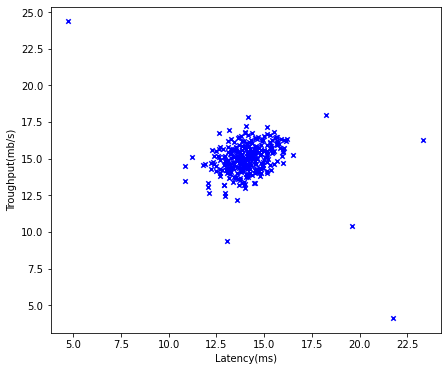

In [3]:
# 可视化数据集
def plot_data(X, newfig=True):
    if newfig:
        plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 0], X[:, 1], marker='x', color='b', s=20)
    plt.xlabel('Latency(ms)')
    plt.ylabel('Troughput(mb/s)')

plot_data(X)

### Gaussian distribution

In [4]:
# 多元高斯分布
def gaussian(X, mu, sigma2):
    m = X.shape[0] # 样本个数
    n = X.shape[1] # 特征个数
    
    if np.ndim(sigma2)==1: 
        sigma2 = np.diag(sigma2)  # 将一维的sigma2转换为对角矩阵，目的是将一元高斯分布（多元高斯分布的特例）转换维多元高斯分布
        
    term = 1. / (np.power(2 * np.pi, n / 2) * np.sqrt(np.linalg.det(sigma2)))
    simg2_inv = np.linalg.inv(sigma2) # 求sigma2的逆矩阵
    exp = np.zeros((m, 1))
    for i in range(m): # 给定x,求p(x)
        exp[i] = np.exp(-0.5 * (X[i] - mu).dot(simg2_inv).dot(X[i] - mu))
    return term * exp

### Estimating parameters for a Gaussian

In [5]:
# 计算mu和sigma^2
def estimate_gaussian(X):
    m = X.shape[0]
    mu = np.sum(X, axis=0) / m
    
    term = (X - mu) ** 2
    sigma2 = np.sum(term, axis=0) / m
    return mu, sigma2
    
estimate_gaussian(X)

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [6]:
# 绘制分布函数的等高线
def plot_conturs(mu, sigma2, newfig=False):
    x = np.linspace(0, 30, 80)
    y = np.linspace(0, 30, 80)
    xv, yv = np.meshgrid(x, y)
    coord_list = [e.ravel() for e in (xv, yv)]
    points = np.vstack(coord_list).T # 点：(x, y)构成的矩阵
    
    z = gaussian(points, mu, sigma2)
    z = np.reshape(z, (x.shape[0], y.shape[0])).T
    
    if newfig:
        plt.figure(figsize=(7, 6))
        
        
    cont_levels = [10**exp for exp in range(-20,0,3)]
    
    plt.contour(xv, yv, z, levels=cont_levels)

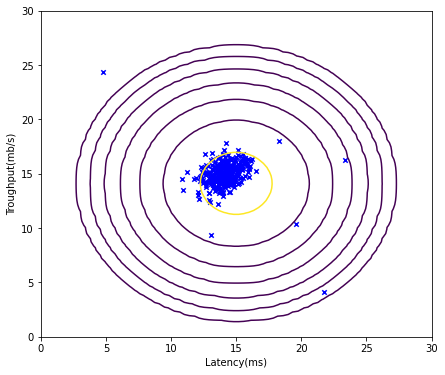

In [7]:
mu, sigma2 = estimate_gaussian(X)

plot_data(X)
plot_conturs(mu, sigma2)

### Selecting the threshold

In [8]:
# 计算F1
def compute_f1(predVec, trueVec):
    
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) if predVec[x]]) \
                    / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) if trueVec[x]]) \
            / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0

# 选择最优的参数epsilon
def select_threshold(pval, yval):
    
    epsilon = np.linspace(np.min(pval), np.max(pval), 1000)
    
    best_f1, best_epsilon = 0, 0
    yval = (yval==1).flatten() # ->1维; int->bool
    
    for eps in epsilon:
        pred = pval < eps
        f1 = compute_f1(pred, yval)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = eps
    return best_f1, best_epsilon

In [9]:
# 计算p(x)
pval = gaussian(Xval, mu, sigma2)

In [10]:
best_f1, best_epsilon = select_threshold(pval, yval)

print('best_f1: ',best_f1)
print('best_epsilon: ', best_epsilon)

best_f1:  0.8750000000000001
best_epsilon:  8.999852631901397e-05


In [11]:
# 绘制异常点
def plot_anomalalies(X, pval, epsilon, newfig=False):
    anom = np.array([X[i] for i in range(X.shape[0]) if pval[i] < epsilon])
    if newfig:
        plt.figure(figsize=(8, 7))
    plt.scatter(anom[:, 0], anom[:, 1], marker='o', s=100, facecolors='none', edgecolors='r')

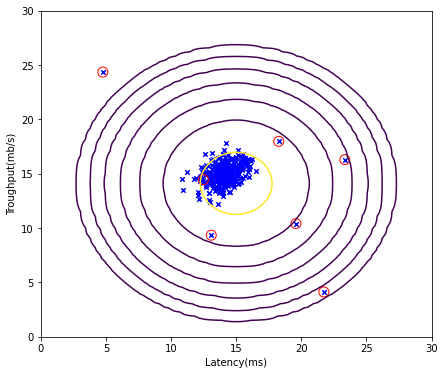

In [12]:
plot_data(X)
plot_conturs(mu, sigma2)
plot_anomalalies(X, pval, best_epsilon)

###  High dimentional dataset

In [13]:
data = loadmat('./data/ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

X.shape, Xval.shape, yval.shape

((1000, 11), (100, 11), (100, 1))

In [14]:
mu, sigma2 = estimate_gaussian(X)

p = gaussian(X, mu, sigma2) # 训练集
pval = gaussian(Xval, mu, sigma2) # 验证集

best_f1, best_epsilon = select_threshold(pval, yval) # 验证集

anoms = len([X[i] for i in range(X.shape[0]) if p[i] < best_epsilon])

print('best_epsilon: ', best_epsilon)
print('anomalies: ', anoms)

best_epsilon:  1.3786074982000245e-18
anomalies:  117
